### **Leitura e Pré-processamento de Dados**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Carregar o dataset
df = pd.read_csv('pesticides.csv')

# --- 1. Inspeção Inicial ---
print("Formato do Dataset:", df.shape)
print("\nTipos de Dados:\n", df.dtypes)
print("\nValores Ausentes:\n", df.isnull().sum())
print("\nPrimeiras Linhas:\n", df.head())

# --- 2. Preparação dos Dados para Regressão ---

# O problema de regressão é prever a coluna 'Value' (Valor)
TARGET = 'Value'

# 2.1. Remoção de Colunas Irrelevantes/Constantes
# 'Domain', 'Element', 'Item', e 'Unit' parecem ter valores constantes ou serem descritivos demais para o modelo inicial.
df.drop(columns=['Domain', 'Element', 'Item', 'Unit'], inplace=True)

# 2.2. Tratamento de Dados Ausentes
# Não há valores ausentes (isnull().sum() é zero para as colunas restantes), mas se houvesse, SimpleImputer seria usado.

# 2.3. Separação de Variáveis Categóricas e Numéricas
# 'Year' é numérico, 'Area' é categórico.
numerical_features = ['Year']
categorical_features = ['Area']

# 2.4. Definição de X (features) e y (target)
X = df.drop(columns=[TARGET])
y = df[TARGET]

# 2.5. Pré-processamento com Pipeline e ColumnTransformer
# Criaremos um ColumnTransformer para aplicar diferentes transformações às colunas.

# Pipeline para Variáveis Numéricas:
# Apenas a variável 'Year' será escalada.
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para Variáveis Categóricas:
# Usaremos OneHotEncoder para transformar países em colunas binárias.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer combina os transformadores:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Manter outras colunas (não há mais neste caso)
)

# 2.6. Divisão dos Dados em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTamanho do conjunto de Treino: {X_train.shape}")
print(f"Tamanho do conjunto de Teste: {X_test.shape}")

Formato do Dataset: (4349, 7)

Tipos de Dados:
 Domain      object
Area        object
Element     object
Item        object
Year         int64
Unit        object
Value      float64
dtype: object

Valores Ausentes:
 Domain     0
Area       0
Element    0
Item       0
Year       0
Unit       0
Value      0
dtype: int64

Primeiras Linhas:
            Domain     Area Element                Item  Year  \
0  Pesticides Use  Albania     Use  Pesticides (total)  1990   
1  Pesticides Use  Albania     Use  Pesticides (total)  1991   
2  Pesticides Use  Albania     Use  Pesticides (total)  1992   
3  Pesticides Use  Albania     Use  Pesticides (total)  1993   
4  Pesticides Use  Albania     Use  Pesticides (total)  1994   

                           Unit  Value  
0  tonnes of active ingredients  121.0  
1  tonnes of active ingredients  121.0  
2  tonnes of active ingredients  121.0  
3  tonnes of active ingredients  121.0  
4  tonnes of active ingredients  201.0  

Tamanho do conjunto de Treino

### **Desenvolvimento e Otimização de Modelos (Regressão)**

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.metrics import mean_squared_error, r2_score

# --- 3. Definição dos Modelos e Espaços de Hiperparâmetros ---

models = {
    'KNN': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVM': SVR(),
    'MLP': MLPRegressor(max_iter=500, early_stopping=True, random_state=42)
}

param_distributions = {
    'KNN': {
        'regressor__n_neighbors': sp_randint(1, 30),
        'regressor__weights': ['uniform', 'distance']
    },
    'DecisionTree': {
        'regressor__max_depth': sp_randint(5, 30),
        'regressor__min_samples_split': sp_randint(2, 20)
    },
    'RandomForest': {
        'regressor__n_estimators': sp_randint(50, 300),
        'regressor__max_depth': sp_randint(5, 25),
        'regressor__min_samples_split': sp_randint(2, 15)
    },
    'SVM': {
        'regressor__C': sp_uniform(loc=0.1, scale=10),
        'regressor__gamma': ['scale', 'auto'],
        'regressor__kernel': ['rbf', 'linear']
    },
    'MLP': {
        'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'regressor__alpha': sp_uniform(loc=0.0001, scale=0.1)
    }
}

best_models = {}
results = []
metrics = {}

# --- 4. Otimização e Treinamento (Iteração) ---

for name, model in models.items():
    print(f"\nIniciando otimização para {name}...")

    # Criação do Pipeline: Preprocessador + Modelo
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

    # Otimização com RandomizedSearchCV
    search = RandomizedSearchCV(
        pipe,
        param_distributions[name],
        n_iter=10,  # 10 iterações de busca aleatória
        cv=3,       # 3-Fold Cross-Validation
        scoring='neg_mean_squared_error', # Métrica de otimização
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_train, y_train)

    # Salvar o melhor modelo e seus hiperparâmetros
    best_models[name] = search.best_estimator_
    best_params = {k.replace('regressor__', ''): v for k, v in search.best_params_.items()}

    # 5. Avaliação
    y_pred = best_models[name].predict(X_test)

    # Métricas de Regressão
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    metrics[name] = {'R2': r2, 'MSE': mse, 'RMSE': rmse}

    results.append({
        'Modelo': name,
        'R2': r2,
        'RMSE': rmse,
        'Melhores Hiperparâmetros': best_params
    })

    print(f"Melhor pontuação (CV Score): {-search.best_score_:.2f}")
    print(f"R² no Teste: {r2:.4f}")

# Exibir tabela final de resultados
results_df = pd.DataFrame(results)
print("\n--- Tabela de Resultados (Regressão) ---")
print(results_df[['Modelo', 'R2', 'RMSE']])


Iniciando otimização para KNN...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhor pontuação (CV Score): 43590619.07
R² no Teste: 0.9988

Iniciando otimização para DecisionTree...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhor pontuação (CV Score): 91781471.91
R² no Teste: 0.9966

Iniciando otimização para RandomForest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhor pontuação (CV Score): 177548419.35
R² no Teste: 0.9940

Iniciando otimização para SVM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhor pontuação (CV Score): 13259808882.02
R² no Teste: -0.0258

Iniciando otimização para MLP...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhor pontuação (CV Score): 12722843101.60
R² no Teste: 0.9297

--- Tabela de Resultados (Regressão) ---
         Modelo        R2           RMSE
0           KNN  0.998815    4566.133126
1  DecisionTree  0.996552    7789.860506
2  RandomForest  0.994012   1

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### Avaliação

In [4]:
# A avaliação foi realizada no loop anterior, apenas formatando o output aqui.
print("\n--- Métricas de Avaliação ---")
print(results_df[['Modelo', 'R2', 'RMSE']])


--- Métricas de Avaliação ---
         Modelo        R2           RMSE
0           KNN  0.998815    4566.133126
1  DecisionTree  0.996552    7789.860506
2  RandomForest  0.994012   10264.964276
3           SVM -0.025818  134356.207363
4           MLP  0.929710   35169.813650


### **Visualização**

/tmp/ipython-input-2527634675.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='RMSE', data=results_df, ax=axes[0], palette='viridis')
/tmp/ipython-input-2527634675.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modelo', y='R2', data=results_df, ax=axes[1], palette='plasma')


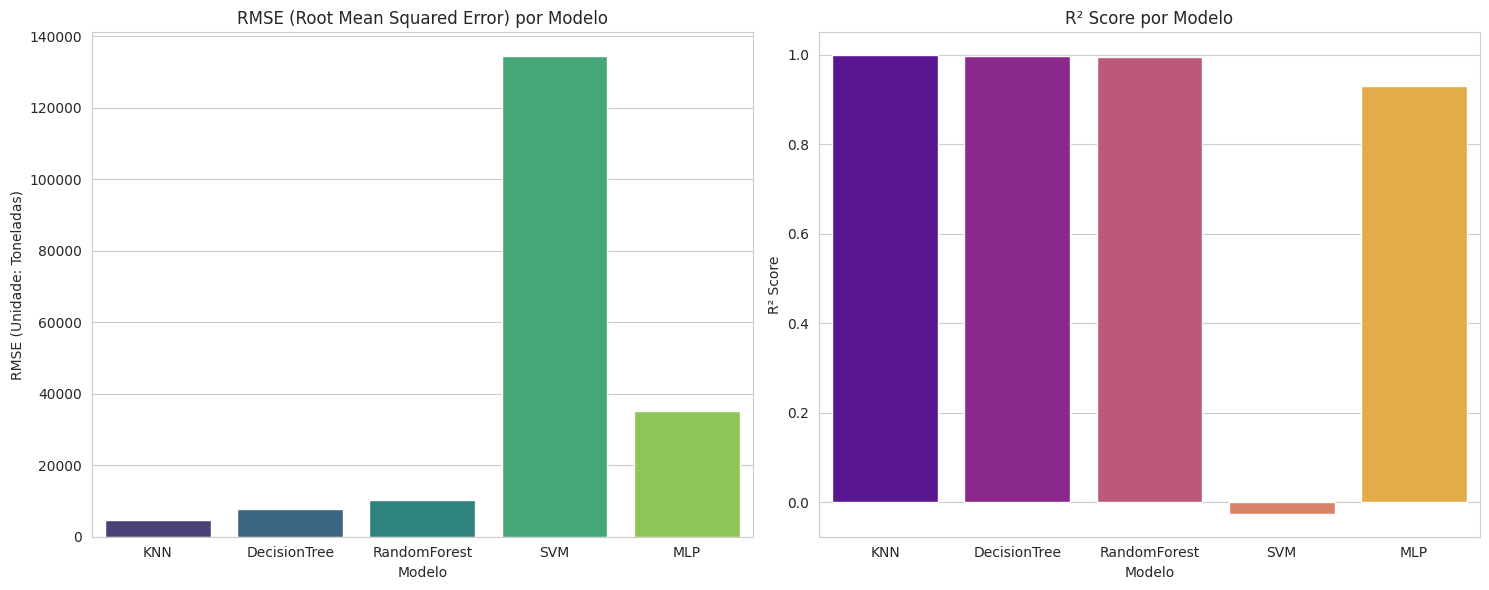

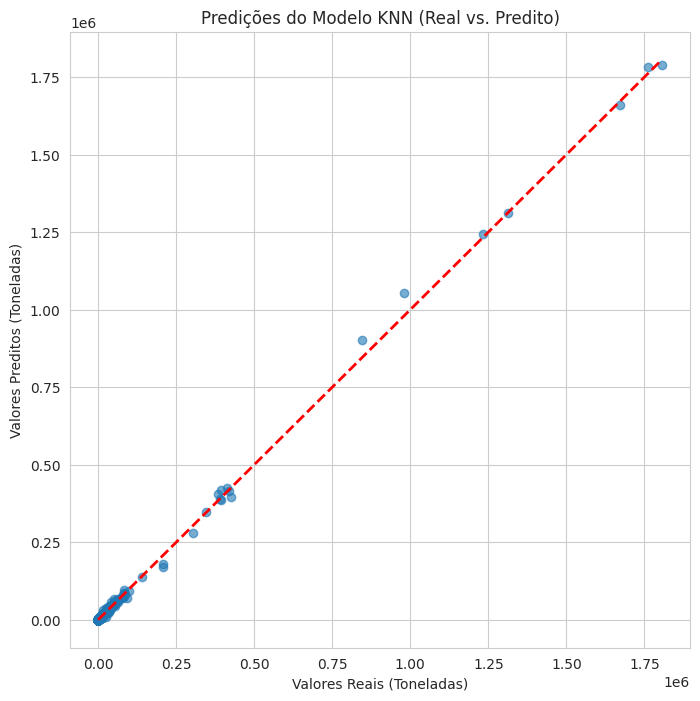

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo para os gráficos
sns.set_style("whitegrid")

# --- Visualização 1: Comparação de Métricas (RMSE e R2) ---

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de RMSE (Quanto menor, melhor)
sns.barplot(x='Modelo', y='RMSE', data=results_df, ax=axes[0], palette='viridis')
axes[0].set_title('RMSE (Root Mean Squared Error) por Modelo')
axes[0].set_ylabel('RMSE (Unidade: Toneladas)')

# Gráfico de R² (Quanto mais próximo de 1, melhor)
sns.barplot(x='Modelo', y='R2', data=results_df, ax=axes[1], palette='plasma')
axes[1].set_title('R² Score por Modelo')
axes[1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

# --- Visualização 2: Análise do Melhor Modelo (Ex: Random Forest) ---
# O melhor modelo é tipicamente o com maior R2 e menor RMSE.
best_model_name = results_df.loc[results_df['R2'].idxmax()]['Modelo']
best_regressor = best_models[best_model_name]
y_pred_best = best_regressor.predict(X_test)

# Plot de Valores Reais vs. Valores Preditos
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reais (Toneladas)')
plt.ylabel('Valores Preditos (Toneladas)')
plt.title(f'Predições do Modelo {best_model_name} (Real vs. Predito)')
plt.show()